# Python para finanças - alocação e otimização de portfólios

## Importação das bibliotecas e base de dados

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
from get_stocks_yfinance import get_stocks_yfinance
from constants import stocks
dataset, days = get_stocks_yfinance(stocks)

In [ ]:
dataset

## Alocação aleatória de ativos

In [ ]:
def stocks_alocation(dataset: pd.DataFrame, total_money: float | int, seed: int = 0, weights = None):
    if seed != 0:
        np.random.seed(seed)
    
    dataset = dataset.copy()
    
    if weights is None:
        weights = np.random.random(len(stocks))
        
    weights = weights / weights.sum()
    
    stocks_weights_df = pd.DataFrame(dict(Ações=stocks.keys(), Pesos=weights))
    stocks_weights_df["Pesos"] = stocks_weights_df["Pesos"].apply(lambda x: f"{x*100:.2f}%")
    
    for column in stocks.values():
        dataset[column] = dataset[column] / dataset[column].iloc[0]
    
    for i, column in enumerate(stocks.values()):
        dataset[column] = dataset[column] * weights[i] * total_money
    
    dataset["total"] = dataset[stocks.values()].sum(axis=1)
    dataset["taxa de retorno"] = 0.0
    dataset["taxa de retorno"] = (dataset["total"] / dataset["total"].shift(1) - 1)
    
    print(f"Valor inciial: {total_money:.2f}")
    print(f"Valor final: {dataset.loc[dataset.index.max(), 'total']:.2f}")
    display(stocks_weights_df)
    
    return dataset

In [ ]:
dataset = stocks_alocation(dataset, 5000)

### Taxa de retorno diária (Gráfico de linha)

In [ ]:
fig = px.line(data_frame=dataset, x=dataset.index, y="taxa de retorno")
fig

### Evolução patrimônio de cada empresa (Gráfico de linha)

In [ ]:
fig = px.line(title="Evolução do patrimônio")
for column in dataset.columns[:-2]:
    fig.add_scatter(x=dataset.index, y=dataset[column], name=column)
fig.update_layout(hovermode="x")
fig

### Evolução patrimônio total (Gráfico de linha)

In [ ]:
px.line(data_frame=dataset, x=dataset.index, y="total", title="Evolução do patrimônio")

## Sharpe Ratio

### Retorno acumulado em todo o período

In [ ]:
print(f"{dataset.iloc[-1, -2] / dataset.iloc[0, -2] * 100:.2f}%")

### Desvio padrão

In [ ]:
dataset["taxa de retorno"].std()

### Sharpe ratio

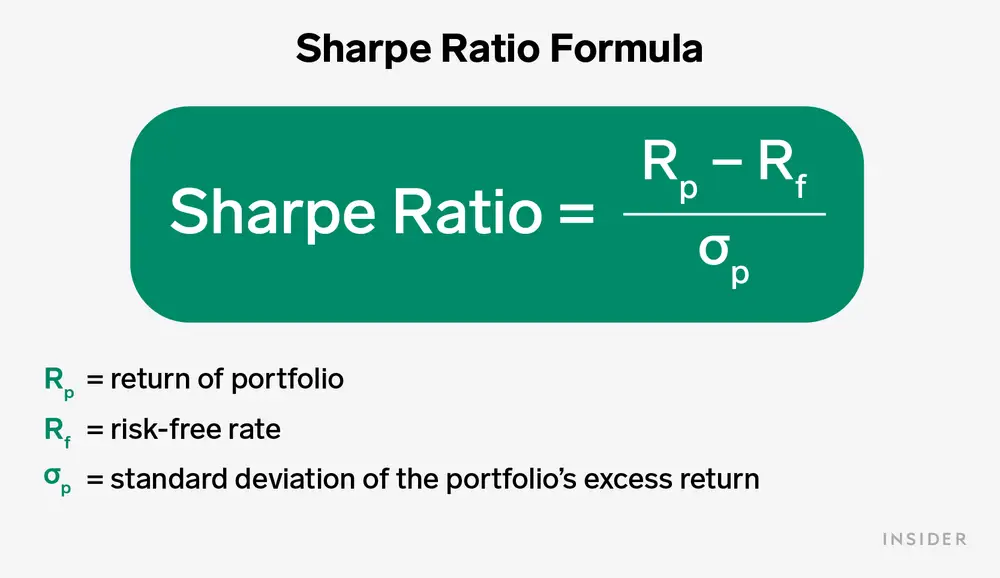

Em geral:
Sharpe Ratio > 1 = aceitável<br>
Sharpe Ratio > 2 = muito bom<br>
Sharpe Ratio > 3 = excelente

Rp -> Retorno esperado do portfólio `dataset["taxa de retorno"].mean()`<br>
Rf -> Retorno sem riscos `média de ganho com taxa selic`<br>
σp -> Desvio padrão do portfólio `dataset["taxa de retorno"].std()`

In [ ]:
# após usar desvio padrão, deve-se tirar a raiz quadrada do número de dias no ano para anualizar
dataset["taxa de retorno"].mean() / (dataset["taxa de retorno"].std()) * np.sqrt(days)

Risk free

In [ ]:
total_money = 5000
# Total final - total investido
profit = dataset["total"].iloc[-1] - total_money
print("Lucro:", profit)
# Taxa selic de cada ano
selic_rates = (
    0.1275, # 2015
    0.1425, # 2016
    0.1225, # 2017
    0.0650, # 2018
    0.050, # 2019
    0.020, # 2020
    0.0775, # 2021
    0.1375, # 2022
    0.12, # 2023
)
# Ano do investimento inicial
year = 2015
# cálcula primeiro ano
years_values = {year: total_money + (total_money * selic_rates[0])}
# itera para todos os anos
for rate in selic_rates[1:]:
    years_values[year+1] = years_values[year] + (years_values[year] * rate)
    year += 1
display(years_values)
# rendimentos
gain = years_values[year] - total_money
print("rendimento selic:", gain)
gain = gain - (gain * 15/100)
print("descontando imposto de renda:", gain)

In [ ]:
dataset["taxa de retorno"].mean()

In [ ]:
np.mean(selic_rates) / days

In [ ]:
# Média diária anualizada
Rp = dataset["taxa de retorno"].mean() * days
# Média taxa selic anual
Rf = np.mean(selic_rates)
# Desvio padrão, após usar desvio padrão é necessário multiplicar pela raiz do número de dias do ano para anualizar
sigma_p = dataset["taxa de retorno"].std()
sharpe_ratio = (Rp - Rf) / (sigma_p * np.sqrt(days))
sharpe_ratio

## Otimização de portfólio - randômico
- Markowitz: https://pt.wikipedia.org/wiki/Teoria_moderna_do_portf%C3%B3lio

In [ ]:
def portfolio_alocation(dataset: pd.DataFrame, total_money: float, no_risk: float, times: int):
    dataset = dataset[stocks.values()].copy()
    original_dataset = dataset[stocks.values()].copy()
    
    best_sharpe_ratio = -np.inf
    best_weights = np.empty
    
    roi_list = []
    volatility_list = []
    sharpe_ratio_list = []
    
    for _ in range(times):
        weights = np.random.random(len(stocks))
        weights = weights / weights.sum()
        
        for column in stocks.values():
            dataset[column] = dataset[column] / dataset[column].iloc[0]
    
        for i, column in enumerate(stocks.values()):
            dataset[column] = dataset[column] * weights[i] * total_money
            
        portfolio_return = np.log(dataset / dataset.shift(1))
        cov_matrix = portfolio_return[stocks.values()].cov()
        
        dataset["total"] = dataset[stocks.values()].sum(axis=1)
        dataset["taxa de retorno"] = 0.0
        dataset["taxa de retorno"] = np.log(dataset["total"] / dataset["total"].shift(1))
        
        # taxa de retorno média anual baseada nos pesos
        roi = np.sum(dataset["taxa de retorno"].mean() * weights) * days
        # volatilidade esperada, soma produto da matrix de covariância anualizada pelos pesos, cujo resultado será utilizado em outra soma produto com os pesos, do valor total é retirada a raiz quadrada
        expected_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix * days, weights)))
        sharpe_ratio = (roi - no_risk) / expected_volatility
        
        roi_list.append(roi)
        volatility_list.append(expected_volatility)
        sharpe_ratio_list.append(sharpe_ratio)
        
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_weights = weights
            best_roi = roi
            best_volatility = expected_volatility
        
        dataset = original_dataset.copy()
    
    print("Melhor sharpe ratio:", best_sharpe_ratio)
    print("Pesos finais:", best_weights)
    return best_sharpe_ratio, best_weights, roi_list, volatility_list, sharpe_ratio_list, best_roi, best_volatility

In [ ]:
sharpe_ratio, weights, roi_list, volatility_list, sharpe_ratio_list, best_roi, best_volatility = portfolio_alocation(dataset, 5000, np.mean(selic_rates), 200)

In [ ]:
_ = stocks_alocation(dataset, 5000, weights=weights)

In [ ]:
roi_volat_sharpe_df = pd.DataFrame({
    "Volatilidade": volatility_list,
    "Retorno do Investimento": roi_list,
    "Sharpe Ratio": sharpe_ratio_list
})

In [ ]:
fig = px.scatter(roi_volat_sharpe_df, x="Volatilidade", y="Retorno do Investimento", color="Sharpe Ratio", color_continuous_scale='viridis')
fig.add_scatter(x=[best_volatility], y=[best_roi], marker=dict(color='red', size=15), showlegend=False, hovertemplate = 'Volatilidade: %{x:.2f}<br>Retorno do Investimento: %{y:.2f}<br>'+f"Sharpe Ratio: {sharpe_ratio}")

## Otimização de portfólio com algoritmos de otimização
- https://mlrose.readthedocs.io/en/stable/

In [ ]:
# pip install mlrose-hiive joblib==1.1.1
import mlrose_hiive

### variables

In [ ]:
original_dataset = dataset.iloc[:, :-2].copy()
total_money = 5000
no_risk = np.mean(selic_rates)

### fitness_function

In [ ]:
def fitness_function(solution):
    dataset = original_dataset.copy()
    weights = solution / solution.sum()
    
    for column in stocks.values():
        dataset[column] = dataset[column] / dataset[column].iloc[0]

    for i, column in enumerate(stocks.values()):
        dataset[column] = dataset[column] * weights[i] * total_money
        
    portfolio_return = np.log(dataset / dataset.shift(1))
    cov_matrix = portfolio_return[stocks.values()].cov()
    
    dataset["total"] = dataset[stocks.values()].sum(axis=1)
    dataset["taxa de retorno"] = 0.0
    dataset["taxa de retorno"] = np.log(dataset["total"] / dataset["total"].shift(1))
    
    # taxa de retorno média anual baseada nos pesos
    roi = np.sum(dataset["taxa de retorno"].mean() * weights) * days
    # volatilidade esperada, soma produto da matrix de covariância anualizada pelos pesos, cujo resultado será utilizado em outra soma produto com os pesos, do valor total é retirada a raiz quadrada
    expected_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix * days, weights)))
    sharpe_ratio = (roi - no_risk) / expected_volatility
    
    return sharpe_ratio

### Testando fitness function

In [ ]:
weights = np.random.random(len(stocks))
weights = weights / weights.sum()
fitness_function(weights)

### Visualizar pesos

In [ ]:
def view_aloc(solution):
    columns = original_dataset.columns
    for i in range(len(solution)):
        print(columns[i], round(solution[i] * 100, 2))

view_aloc(weights)

### Definição do problema de otimização

In [ ]:
fitness = mlrose_hiive.CustomFitness(fitness_function)

### Maximization and Minimization problems

In [ ]:
maximization_problem = mlrose_hiive.ContinuousOpt(
    length=len(stocks.values()), # quantos valores serão gerados
    fitness_fn=fitness, # fitness function
    maximize=True,               # problema de maximização
    min_val=0,                   # valores entre 0 e 1
    max_val=1,                   # valores entre 0 e 1
)

minimization_problem = mlrose_hiive.ContinuousOpt(
    length=len(stocks.values()), # quantos valores serão gerados
    fitness_fn=fitness, # fitness function
    maximize=False,               # problema de minimização
    min_val=0,                   # valores entre 0 e 1
    max_val=1,                   # valores entre 0 e 1
)

### Hill Climb

#### max

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.hill_climb(maximization_problem)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)

#### min

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.hill_climb(minimization_problem)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)

### Simulated annealing

#### max

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.simulated_annealing(maximization_problem)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)

#### min

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.simulated_annealing(minimization_problem)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)

### Algoritmo genético

In [ ]:
maximization_problem_ag = mlrose_hiive.ContinuousOpt(
    length=len(stocks.values()), # quantos valores serão gerados
    fitness_fn=fitness, # fitness function
    maximize=True,               # problema de maximização
    min_val=0.1,                   # valores entre 0 e 1
    max_val=1,                   # valores entre 0 e 1
)

minimization_problem_ag = mlrose_hiive.ContinuousOpt(
    length=len(stocks.values()), # quantos valores serão gerados
    fitness_fn=fitness, # fitness function
    maximize=False,               # problema de minimização
    min_val=0.1,                   # valores entre 0 e 1
    max_val=1,                   # valores entre 0 e 1
)

#### max

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.genetic_alg(maximization_problem_ag)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)

#### min

In [ ]:
best_solution, best_cost, curve = mlrose_hiive.genetic_alg(minimization_problem_ag)
best_solution = best_solution / best_solution.sum()
view_aloc(best_solution)
print("Sharpe Ratio:", best_cost)
_ = stocks_alocation(dataset, 5000, weights=best_solution)